<h1 style="text-align:center">Mega Project 2</h1>

<h2>Abstract</h2>

This project focuses on different methods for solving the linear least squares problem and its application in designing a multiple linear regression model. It first begins by proposing methods for solving the least squares in the matrix decomposition field. Precisely, we will use different decompositions like LU,Cholesky,QR,and SVD to solve square and non-square problems. We'll discuss on methods and suggestions for using these decompositions in the field of tensor factorization as well. 

Second, iterative methods like the Gauss-Seidel and Successive Over-Relaxation (SOR) will be studied for approximating the solution. Their advantages, disadvantages, and limitations will be compared with the decompostion methods and conclusions will be drawn.

Third, a linear multiple regression model will be designed based on our methods from the previous parts. The model will include evaluations on the overall performance of the model, identifying correlations between the variables, correlations between each variable and the response, and sensitivity analysis of the coefficients (statistical significance).

Eventually, we will test this model on the Boston dataset by fitting it on the train data, and making predictions on the test data. As evaluating the performance and correlation analysis depends heavily on the data we're working with, the last two parts will be combined in a single phase.

<h2>Phase 1</h2>

As mentioned above, the purpose of this phase is to use LU,Cholesky,QR,SVD, and Truncated SVD decompositions and solve the linear least squares problem with it. 

The linear least squares problem is defined as Ax=b, where A is our data matrix, b is the response, and our purpose is to approximate or find an exact solution x, that is, to find min||Ax-b||. 

Assume that A has m rows and n columns. There are three possible scenarios: 

1. m=n 2. m<n 3. m>n

In the first case (A is square), the number of equations and unknowns are the same, so we have a unique solution. All decompositions mentioned above can be used for this case. (The Cholesky decomposition is an exception, it is a speciall case of the LU decomposition, it is used only when the matrix is square,symmetric, and positive definite). 

In the second case (A is non-square), there are more unknowns than equations, and the system is called under-determined. In this case, the system doesn't have a unique solution. Of all the decompositions mentioned above, only the SVD can solve this case by making adjustments, but we won't get into it.

In the third case (A is non-square) the opposite of the previous scenario happens. There are more equations than unknowns, and the system is called over-determined. In general such a system has no solution, but we can still minimize ||Ax-b|| and find an approximate unique solution. The QR and SVD decompositions can both do that.

If A is non-singular and the system has a unique solution (case 1), then the solution can always be found directly by computing x=A^-1b, but this is compuationally expensive specially if A is dense and has huge dimensions. Also, if the system has the conditions of case 2,3 and A is singular, the direct method is not applicable. That's why using the decompositions is essential, and a perfect alternative. 



With this preview, let's get to work. We start by loading the essential packages:

In [1]:
import numpy as np
import scipy.linalg as la
import pandas as pd
from sklearn.utils.extmath import randomized_svd
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

We start by defining the LU solver function, that is, a function which takes the data matrix A and a response vector B and returns the least square solution using the LU decomposition. A should be square. Line 2 calls the lu_factor function from scipy, which factorizes A based on LU decomposition with partial pivoting. Line 3 finds the solution x given the LU factors and B with the lu_solve function from scipy, and x is returned.

In [2]:
def LU_Solver(A,B):
    LU = la.lu_factor(A)
    x = la.lu_solve(LU,B)
    return x

To show how the function works, we define matrices A1 and B1 as an example and tend to solve Ax=B. We calculate x both directly and with the LU solver function, and compare the results:

In [3]:
A1 = np.array([[2,1,1],[1,3,2],[1,0,0]])
B1 = np.array([4,5,6])
print('A1:')
print(A1)
print('B1:')
print(B1)
print('Actual x:')
print(la.solve(A1,B1))
print('LU solver x:')
print(LU_Solver(A1,B1))

A1:
[[2 1 1]
 [1 3 2]
 [1 0 0]]
B1:
[4 5 6]
Actual x:
[  6.  15. -23.]
LU solver x:
[  6.  15. -23.]


The answers are the same, so the function works correctly. 

Next we define Cholesky Solver, which solves the system using the Cholesky decomposition. The input matrix should be square,symmetric, and positive definite. The function decomposes A with the Cholesky decomposition in line 2. So we have A=(U.T)(U). So instead of Ax=B we have (U.T)Ux=B. So we solve x=Uy, where y=U.TB in lines 3 and 4.

In [4]:
def Cholesky_Solver(A,B):
    U = la.cholesky(A,lower=False)
    y = la.solve(U.T,B)
    x = la.solve(U,y)
    return x

Like the previous part, let's demonstrate an example:

In [5]:
A2 = np.array([[6, 3, 4, 8], [3, 6, 5, 1], [4, 5, 10, 7], [8, 1, 7, 25]])
B2 = np.array([4,5,6,7])
print('A2:')
print(A2)
print('B2:')
print(B2)
print('Actual x:')
print(la.solve(A2,B2))
print('Cholesky solver x:')
print(Cholesky_Solver(A2,B2))

A2:
[[ 6  3  4  8]
 [ 3  6  5  1]
 [ 4  5 10  7]
 [ 8  1  7 25]]
B2:
[4 5 6 7]
Actual x:
[-0.15286624  0.81528662  0.05732484  0.28025478]
Cholesky solver x:
[-0.15286624  0.81528662  0.05732484  0.28025478]


QR Solver is defined below. Line 2 decomposes A into matrices Q and R, and the next lines solve the system. In other words, Ax=B and A=QR. So, QRx=B. Now we solve x=Ry where y=QB. A can be both square and non-square here.  

In [6]:
def QR_Solver(A,B):
    Q,R = la.qr(A) 
    y = la.solve(Q,B)
    x = la.solve(R,y)
    return x

We demonstrate a square example:

In [7]:
print('A1:')
print(A1)
print('B1:')
print(B1)
print('Actual x:')
print(la.solve(A1,B1))
print('QR solver x:')
print(QR_Solver(A1,B1))

A1:
[[2 1 1]
 [1 3 2]
 [1 0 0]]
B1:
[4 5 6]
Actual x:
[  6.  15. -23.]
QR solver x:
[  6.  15. -23.]


The SVD Solver function for an overdetermined system is defined below, meaning that A can be square or non-square, with more rows than columns. Line 2 decomposes A into the singular values and vectors, and line 3 approximates x using theorems from linear algebra. In other words, we have A=U*diag(s)*VT and x=V*diag(s)^(-1)*B.

In [8]:
def Overdetermined_SVD_Solver(A,B):
    U,s,Vh = la.svd(A,full_matrices=False)
    x = np.array(Vh.T @ la.inv(np.diag(s)) @ U.T @ B)
    return x

We propose a non-square example from the original text-book. As the system is over-determined, we can't use the direct method to compare our answers. But the example can be found and checked in the textbook.

In [9]:
A3 = np.array([[1,1],[1,2],[1,3],[1,4],[1,5]])
B3 = np.array([7.97,10.2,14.2,16,21.2])
print('A3:')
print(A3)
print('B3:')
print(B3)
print('SVD solver x:')
print(Overdetermined_SVD_Solver(A3,B3))

A3:
[[1 1]
 [1 2]
 [1 3]
 [1 4]
 [1 5]]
B3:
[ 7.97 10.2  14.2  16.   21.2 ]
SVD solver x:
[4.236 3.226]


As the final part, we implement the truncated SVD decomposition. This can be used for all 3 case scenarios mentioned above, and is mainly used when we don't need the exact x, but want a close approximation. Thus, we can solve the system using only the largest singular values and vectors instead of the entire set. That is done in line 2 by using randomized_svd, and choosing the 2 largest singular components only. Line 3 calculates x by using the formula similar to the previous SVD solver, with the difference that it uses the 2 largest singular values and vectors to approximate x.

In [10]:
def Truncated_SVD_Solver(A,B):
    U,s,Vh = randomized_svd(A,n_components=2,random_state=None)
    x = np.array(Vh.T @ la.inv(np.diag(s)) @ U.T @ B)
    return x

Two examples are shown here. The first one is an overdetermined system, and we'll use the truncated svd with 2 components to find x. We'll compare the answer with the one found by the regular SVD solver above, which uses all 5 components of A4 to find the answer:  

In [11]:
A4 = np.array([[0,0,0,1,0],[0,0,0,0,1],[0,0,0,0,1],[1,0,1,0,0],[1,0,0,0,0],[0,1,0,0,0],[1,0,1,1,0],[0,1,1,0,0],[0,0,1,1,1],[0,1,1,0,0]])
B4 = np.array([0,0,0,0,0,0,0,1,1,1])
print('A4:')
print(A4)
print('B4:')
print(B4)
print('Actual x:')
print(Overdetermined_SVD_Solver(A4,B4))
print('Truncated SVD solver x:')
print(Truncated_SVD_Solver(A4,B4))

A4:
[[0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [1 0 1 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [1 0 1 1 0]
 [0 1 1 0 0]
 [0 0 1 1 1]
 [0 1 1 0 0]]
B4:
[0 0 0 0 0 0 0 1 1 1]
Actual x:
[-4.44444444e-01  2.22222222e-01  6.66666667e-01  1.11022302e-16
  1.11111111e-01]
Truncated SVD solver x:
[ 0.11684062  0.32821433  0.37416071  0.03986541 -0.04726654]


The answers are quite different, and if we increase the number of components to 3 or 4, we'll see that it gets closer to the correct guess. In the case of 5 components, the answers will be the same. We should remember that the purpose of truncated SVD is not to give exact correct answers, but rather to find a close enough guess with less computational power. This becomes significant as the dimension increases, and using all singular values is not logical, like the example below.

We'll randomly generate a matrix with 80 rows and 100 columns, and a response vector of size 80, and use Truncated SVD to solve the underdetermined system:

In [12]:
A5 = np.random.rand(80,100)
B5 = np.random.rand(80,1)
print('A5:')
print(A5)
print('B5:')
print(B5)
print('Truncated SVD solver x:')
print(Truncated_SVD_Solver(A5,B5))

A5:
[[0.80093634 0.5791187  0.94096848 ... 0.23480426 0.05063032 0.82683014]
 [0.27008074 0.19504592 0.186218   ... 0.30389459 0.70910247 0.37165586]
 [0.04300316 0.78298249 0.68312014 ... 0.63596205 0.41163947 0.89966785]
 ...
 [0.73554937 0.13771676 0.89315616 ... 0.08489519 0.84342012 0.89266395]
 [0.21021554 0.81726436 0.63677492 ... 0.17858873 0.89325843 0.0951164 ]
 [0.27389311 0.49930318 0.38661011 ... 0.37408678 0.33701808 0.49900164]]
B5:
[[0.6709085 ]
 [0.60616816]
 [0.24856055]
 [0.1235389 ]
 [0.76957511]
 [0.97865173]
 [0.85297992]
 [0.29380656]
 [0.77012006]
 [0.67470157]
 [0.23215766]
 [0.06678344]
 [0.07464394]
 [0.37039255]
 [0.75304   ]
 [0.80481449]
 [0.56324913]
 [0.3174953 ]
 [0.1083288 ]
 [0.6861584 ]
 [0.06899244]
 [0.18351616]
 [0.82604269]
 [0.26080178]
 [0.806923  ]
 [0.71082319]
 [0.19176732]
 [0.7213873 ]
 [0.68802629]
 [0.73498796]
 [0.29561948]
 [0.27648163]
 [0.61401778]
 [0.44108871]
 [0.467343  ]
 [0.73830183]
 [0.85239615]
 [0.01783077]
 [0.00840391]
 [

The purpose of this example is to demonstrate the computational power of Truncated SVD in large linear systems, and also to show that it can be used in any system needed (all 3 case scenarios).

Before moving on to the next phase, we would like to propose suggestions and ideas about the extension of matrix decompositions to tensor factorizations. 

Take the SVD decomposition for instance. In matrix spaces, we can perfectly decompose a matrix to its singular vectors and values in the form of A=U* diag(sigma)* VT. The decomposition can be extended to a generalized form and used to factorize tensors as well. It's called the Tucker decomposition, or Higher Order SVD (HOSVD). A tensor called A with dimensions of l,m,n can be decomposed to a format of A= S * U(1) * U(2) * U(3), where U(1) is a (l,l) matrix, U(2) is a (m,m) matrix, U(3) is a (n,n) matrix, and they're orthogonal, and * indicates the 1-mode multiplication of tensor by matrix. S is a tensor with the same dimensions as A, and has the property of all-orthogonality. The 1-mode singular values of A are defined as ||S(i,:,:)||F for each singular value, where the values are ordered decreasingly. The singular values in other modes are defined similarly. The HOSVD allows the same broad range of applications in Tensor spaces which SVD did in matrix spaces, such as tensor approximations.  

The HOSVD is one instance of a process called matricization, and can be extended to any other matrix decomposition. Let's explore the process. Let's assume that we have a tensor with d dimensions, or modes. We can take a dimension, the first one for example, and vary along it while fixing all other modes. This creates a vector. If we repeat the process for all values of the dimensions and create vectors, and then concatenate these vectors together, we can obtain a representation of the tensor as a matrix of dimensions 1x(23...d). We can call this the 1-mode matricization of the tensor. The same can be applied to other dimensions.

Let's return to HOSVD. What it does is to take i(=1...d), and the i-mode matricization of the tensor and use SVD on it. Combining the matrices resulted from this gives us a matrix according to each dimension and a tensor. Therefore, we can say that what we actually do is concatenating the matrices and running SVD on it. The same process can be repeated for any other decomposition, and generalized applications of QR, LU,... can be made posssible in tensor spaces.

<h2>Phase 2</h2>

The second phase is dedicated to iterative methods of solving the least squares problem. Two methods are implemented, the Gauss-Seidel and the SOR. 

The Gauss-Seidel method is implemented below. It takes matrices A,B as an input, as well as an initial guess of the x, and the number of iterations we desire. In lines 2,3 the function splits A into a lowertriangular matrix L and an uppertriangular matrix U, that is, A=L+U. Then it finds x in a iterative manner by repeating the formula x(k+1)=L^-1(B-Ux(k)) n times.

In [13]:
def Gauss_Seidel_Solver(A, B, x, n):
    L = np.tril(A)
    U = A - L
    for i in range(n):
        x = np.dot(np.linalg.inv(L), B - np.dot(U, x))
    return x

An example is presented. We will solve the system using the LU decomposition method from phase 1, and compare it with the answer obtained from the Gauss Seidel solver. 

In [14]:
A6 = np.array([[4.0, -2.0, 1.0], [1.0, -3.0, 2.0], [-1.0, 2.0, 6.0]])
B6 = np.array([1,2,3])
init_guess = np.array([1,1,1])

print('A6:')
print(A6)
print('B6:')
print(B6)
print('LU solver x:')
print(LU_Solver(A6,B6))
print('Gauss Seidel solver x:')
print(Gauss_Seidel_Solver(A6,B6,init_guess,20))

A6:
[[ 4. -2.  1.]
 [ 1. -3.  2.]
 [-1.  2.  6.]]
B6:
[1 2 3]
LU solver x:
[-0.04109589 -0.28767123  0.5890411 ]
Gauss Seidel solver x:
[-0.04109589 -0.28767123  0.5890411 ]


The answers are equal. Next we implement SOR. SOR is another variant of the Gauss Seidel method, but converges faster. It takes A,B,and an initial guess of x, as an input, similar to the Gauss Seidel method, but also an omega parameter which is called the relaxation factor or rate, and the convergence criteria (named tol here). In line 3, we calculate the residual of the system with the initial guess, that is, if Ax=B, we calculate r=||Ax-B||. This is the residual which we want to minimize. We repeat the SOR calculations until r is smaller than the predefined convergence criteria (tol). 

Lines 4 to 11 calculate x using the forward substitution formula (provided in the Wikipedia article about SOR) in the SOR method, that is:
<img src='1.PNG'>


In [15]:
def SOR_Solver(A, B, omega, initial_guess, tol):
  phi = initial_guess[:]
  r = la.norm(np.matmul(A, phi) - B) 
  while r > tol:
    for i in range(A.shape[0]):
      sigma = 0
      for j in range(A.shape[1]):
        if j != i:
          sigma += A[i][j] * phi[j]
      phi[i] = (1 - omega) * phi[i] + (omega / A[i][i]) * (B[i] - sigma)
    r = la.norm(np.matmul(A, phi) - B)
  return phi

An example is given below, and compared with the answer from the LU decomposition for verification. 

In [16]:
A7 = np.array([[4, -1, -6,0], [-5, -4, 10,8], [0,9,4,-2],[1,0,-7,5]])
B7 = np.array([2,21,-12,-6])
init_guess2 = np.zeros(4)
print('A7:')
print(A7)
print('B7:')
print(B7)
print('LU Solver x:')
print(LU_Solver(A7,B7))
print('SOR solver x:')
print(SOR_Solver(A7,B7,0.5,init_guess2,1e-8))

A7:
[[ 4 -1 -6  0]
 [-5 -4 10  8]
 [ 0  9  4 -2]
 [ 1  0 -7  5]]
B7:
[  2  21 -12  -6]
LU Solver x:
[ 3. -2.  2.  1.]
SOR solver x:
[ 3. -2.  2.  1.]


Before moving on to the next part, let's discuss the limiations and advantages of the iterative methods over the decompositions. The biggest limitations in the iterative methods are the fact that they don't guarantee to converge. That is, we don't necessarily have an answer. The methods can be applied to any matrix with non-zero diagonal elements, but only those with diagonal dominance, or those which are symmetric and positive definite are guranateed to converge. Also, they have to be square, and over/under determined systems can't be solved using the iterative algorithms.

With that being said, they still have advantages over the decomposition methods. We'll address some of the disadvantages of decompositions for that matter.

The LU decomposition, for instance, can produce non-zero elements in L and U, in locations where the original matrix has zeros. If this happens a lot, the least squares process becomes computationally costly. Also, in many cases, we have a close intitial guess of the answer, as we saw in both iterative algorithms, and making use of the intiall guess helps us get to the real answer faster, and with less calculations. Decompositions don't have that option, and no initial guess can help them. As a last point, in many occasions where the matrix is large and expensive to compute, we don't even have the initial matrix to start with, and only matrix-vector products are given. Iterative methods have no problem with that, while decopositions fail when there's no matrix to decompose directly.

<h2>Phases 3,4</h2>

In these phases we can put the methods from phase 1 and 2 to action. We will design a multiple linear regression model from scratch, and we'll use the overdetermined SVD solver to determine the coefficients of the model from the error objective function, instead of direct methods or the usual gradient descent. We'll then apply the model on the Boston dataset, make predictions, evaluate the model, and analyse the coefficient significance and variable correlations.

The entire model is defined in the class below. We implement multiple linear regression with ordinary least squares objective function. The init function in lines 3 and 4 initialize the coefficients parameter as an empty list. This is the parameter that would be used to store the calculated coefficients (weights) of the model. 

Functions reshape_x and concatenate_ones are helper functions used in the fit function. The first one is used to reshape the data matrix X in case it only has one feature. The second function concatenates a vector of ones to the beginning of the feature matrix. If we don't preprocess our matrix using these two functions, the model won't work correctly.

Lines 6 to 10 define one the most important parts of the model, the fit function. The training part is done here. In other words, we fit the model on the training data using this function and learn the model coefficients (weights) in the multiple regression model y=w0 +w1x1 +...+ wnxn. We implement the fit function by preprocessing X using the helper functions first. In other words, we check if X has only one feature, and if that is the case, we reshape it. Then we concatenate a vector of ones to its beginning. This is where the least squares method from the previous phases come in. The whole process of calculating the coefficients can be summarized in solving the least squares problem min||Xw-Y||. The set of coefficients minimizing the residual mentioned are the optimal coefficients. Normally, we would estimate them using an iterative method like gradient descent or simply by using the direct method, but now, we can simply solve the overdetermined system by our SVD Solver function from phase 1. We can obviously use other functions defined in phases 1 and 2, but SVD solver serves our purpose best in this part. Thus, line 10 finds the coefficients of the model by calling the SVD solver function and giving the data matrix X and the response variable y as input. Then it stores the coefficients in the list.

The second most important function is the predict function, which, given test data, should use the learned model and predict responses. We implement it by substituting the test values in the linear model y=w0+w1x1+...+wnxn, with determined coefficients from the fit function, and calculating y using the coefficients and the x values.

That's a wrap on the model. We're ready to use it on the Boston dataset.

In [17]:
class Multiple_Regression(object):
    
    def __init__(self):
        self.coefficients = []
        
    def fit(self,X,y):
        if len(X.shape)== 1: X= self._reshape_x(X)
        
        X = self._concatenate_ones(X)
        self.coefficients = Overdetermined_SVD_Solver(X,y)
        
    def predict(self,entry):
        b0 = self.coefficients[0]
        other_betas = self.coefficients[1:]
        prediction = b0
        
        for xi ,bi in zip(entry,other_betas): prediction += (bi*xi)
        return prediction
    
    def _reshape_x(self,X):
        return X.reshape(-1,1)
    
    def _concatenate_ones(self, X):
        ones = np.ones(shape=X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X),1)
    
    pass

We load the boston dataset and take a look at it. The boston housing dataset is used to predict the price of houses. We have 506 samples and 14 columns, 13 of which are features, and medv is the response variable, the price we intend to predict. The features are related to the condition the houses are in. 

In [18]:
boston = pd.read_csv('BostonHousing.csv')
print(boston.head())
print(boston.shape)

      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        b  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  
(506, 14)


After loading the dataset, we split the features from the response, and store them in variables X and y.

In [19]:
X = boston.drop('medv',axis=1).values
y = boston['medv'].values

Now, we split the variables into train and test sets with a 0.2 test size.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We create an object from our model class, and fit it on the train data. Then, we print the coefficients. Now we know that the model was trained on the data, and the coefficients were calculated using our SVD solver.

In [21]:
model = Multiple_Regression()
model.fit(X_train,y_train)
coeffs= model.coefficients
print(coeffs)

[ 3.02467510e+01 -1.13055924e-01  3.01104641e-02  4.03807204e-02
  2.78443820e+00 -1.72026334e+01  4.43883520e+00 -6.29636221e-03
 -1.44786537e+00  2.62429736e-01 -1.06467863e-02 -9.15456240e-01
  1.23513347e-02 -5.08571424e-01]


It's time to make predictions and test the performance of the model. We define two empty lists, for storing the predictions.

In [22]:
y_train_pred = []
y_test_pred = []

Next, we predict the response variable for each row (sample) of the train set and store the prediction in the list.

In [23]:
for row in X_train: y_train_pred.append(model.predict(row))
y_train_pred = np.array(y_train_pred)

We do the same on the test data. The previous part is intended to calculate the train error, while the main job is to predict the test data and calculate the test error. We need the train error as well, so that we can compare it to the test data and determine whether the model is overfittting.

In [24]:
for row in X_test: y_test_pred.append(model.predict(row))
y_test_pred = np.array(y_test_pred)

We create a dataframe containing the actual test y values, and the ones predicted by the model, and compare them.

In [25]:
result = pd.DataFrame({'Actual': y_test, 'Predicted':y_test_pred })
print(result)

     Actual  Predicted
0      23.6  28.996724
1      32.4  36.025565
2      13.6  14.816944
3      22.8  25.031979
4      16.1  18.769880
..      ...        ...
97     17.9  -0.164237
98      9.6  13.684867
99     17.2  16.183597
100    22.5  22.276220
101    21.4  24.479024

[102 rows x 2 columns]


Consider the first value as an example. The actual y is 23.6, while the model predicted 28. The values are close enough, and the model doesn't perform that bad. A visual comparison is also given below, for the first 10 values.

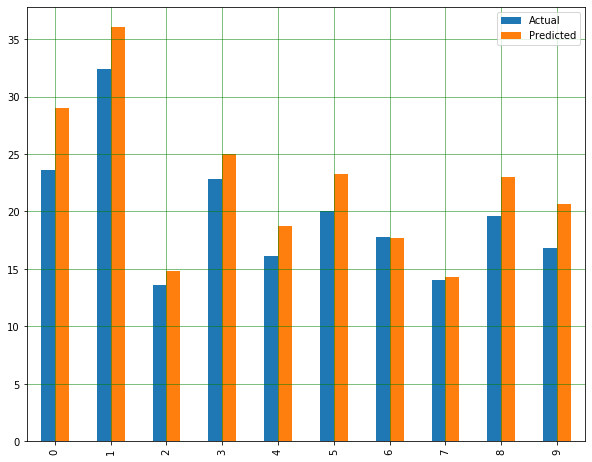

In [26]:
result.head(10).plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

The plot clearly shows that the predicted values by our model are close to the actual values. Let's get a more clear vision about the model performance by calculating the test and train Minimum Square Errors (MSE) and accuracies.

The train MSE and accuracy:

In [27]:
MSE_train = (np.mean(np.power((y_train - y_train_pred),2)))/100
Accuracy_train = 1 - MSE_train

The test MSE and accuracy:

In [28]:
MSE_test = (np.mean(np.power((y_test - y_test_pred),2)))/100
Accuracy_test = 1 - MSE_test

Besides test and train MSEs and accuracies, we are interested in the train RSS and TSS, so that we can calculate the R2 and F statistics for the trained model, which are other evaluation metrics about how good a model has been trained.

We obtain parameters and values necessary for the calculations:

In [29]:
n = X_test.shape[0]
p = X_test.shape[1]
y_train_mean = np.mean(y_train)

The scores are calculated according to some simple statistical formulas:

In [30]:
RSS_train = np.sum(np.power((y_train - y_train_pred),2))
TSS_train = np.sum(np.power((y_train - y_train_mean),2))
R2 = 1 - (RSS_train / TSS_train)
F_score = ((TSS_train - RSS_train)/p)/(RSS_train/(n-p-1))

We combine all the evaluation metrics calculated in a single dataframe and print it below:

In [31]:
model_evals = pd.DataFrame({'Train Error':[MSE_train], 'Test Error':[MSE_test], 'Train Accuracy':[Accuracy_train],'Test Accuracy':[Accuracy_test], 'R2': [R2], 'F-statistic':[F_score] })
print(model_evals)

   Train Error  Test Error  Train Accuracy  Test Accuracy        R2  \
0     0.216414    0.242911        0.783586       0.757089  0.750886   

   F-statistic  
0    20.403955  


The train and test errors and accuracies show a good result. The train and test accuracies are both around 0.75, which is fairly good for a model that has been built from scratch, without any packages and overall optimizations. The accuracies are close to each other, which means that the model has not encountered any overfitting. As another metric, we take a look at R2, which is also 0.75. This is another evidence at the quality of the model fit. Also, the F-statistic stands at 20.4, a value far away from 1, which means that the overall performance of the model is fairly good.

As a last step, we analyze the model from the point of correlations and statistical significance.

Let's calculate the correlation matrix for the dataset, to obtain the variables correlated to each other:

In [32]:
cc = boston.corr()
print(cc)

             crim        zn     indus      chas       nox        rm       age  \
crim     1.000000 -0.200469  0.406583 -0.055892  0.420972 -0.219247  0.352734   
zn      -0.200469  1.000000 -0.533828 -0.042697 -0.516604  0.311991 -0.569537   
indus    0.406583 -0.533828  1.000000  0.062938  0.763651 -0.391676  0.644779   
chas    -0.055892 -0.042697  0.062938  1.000000  0.091203  0.091251  0.086518   
nox      0.420972 -0.516604  0.763651  0.091203  1.000000 -0.302188  0.731470   
rm      -0.219247  0.311991 -0.391676  0.091251 -0.302188  1.000000 -0.240265   
age      0.352734 -0.569537  0.644779  0.086518  0.731470 -0.240265  1.000000   
dis     -0.379670  0.664408 -0.708027 -0.099176 -0.769230  0.205246 -0.747881   
rad      0.625505 -0.311948  0.595129 -0.007368  0.611441 -0.209847  0.456022   
tax      0.582764 -0.314563  0.720760 -0.035587  0.668023 -0.292048  0.506456   
ptratio  0.289946 -0.391679  0.383248 -0.121515  0.188933 -0.355501  0.261515   
b       -0.385064  0.175520 

The correlation matrix shows variables which are correlated to each other. The closer the value between two variables to 1, the more they are positively correlated. The same applies to -1, which means that they are negatively correlated. 0 means no correlations are present. For instance, the value between rad and tax is 0.91, very close to 1, so they're positively correlated. Increasing the value of rad will increase the value of tax. In contrast, the value between chas and tax is -0.03, very close to 0. So they are not correlated in any way.

Let's analyze the correlations between the features and the response variable, medv. The analysis shows which variables are important in the process of predicting the house prices, and which are not. The more a variable is correlated to the response, the more important it is:

In [33]:
cc2 = boston[boston.columns[1:]].corr()['medv'][:]
print(cc2)

zn         0.360445
indus     -0.483725
chas       0.175260
nox       -0.427321
rm         0.695360
age       -0.376955
dis        0.249929
rad       -0.381626
tax       -0.468536
ptratio   -0.507787
b          0.333461
lstat     -0.737663
medv       1.000000
Name: medv, dtype: float64


This column shows how the variables are correlated to medv. It appears, for instance, that lstat is highly negatively correlated to medv, meaning that increasing lstat will decrease medv and vice versa. Chas, on the other hand, appears to have no correlation to medv, so it isn't that important in the prediction process and may be eliminated.

With that being said, here's a visual presentation of all the feature correlations to each other, which is more clear than numbers. Diagonal scatter plots indicate correlations.

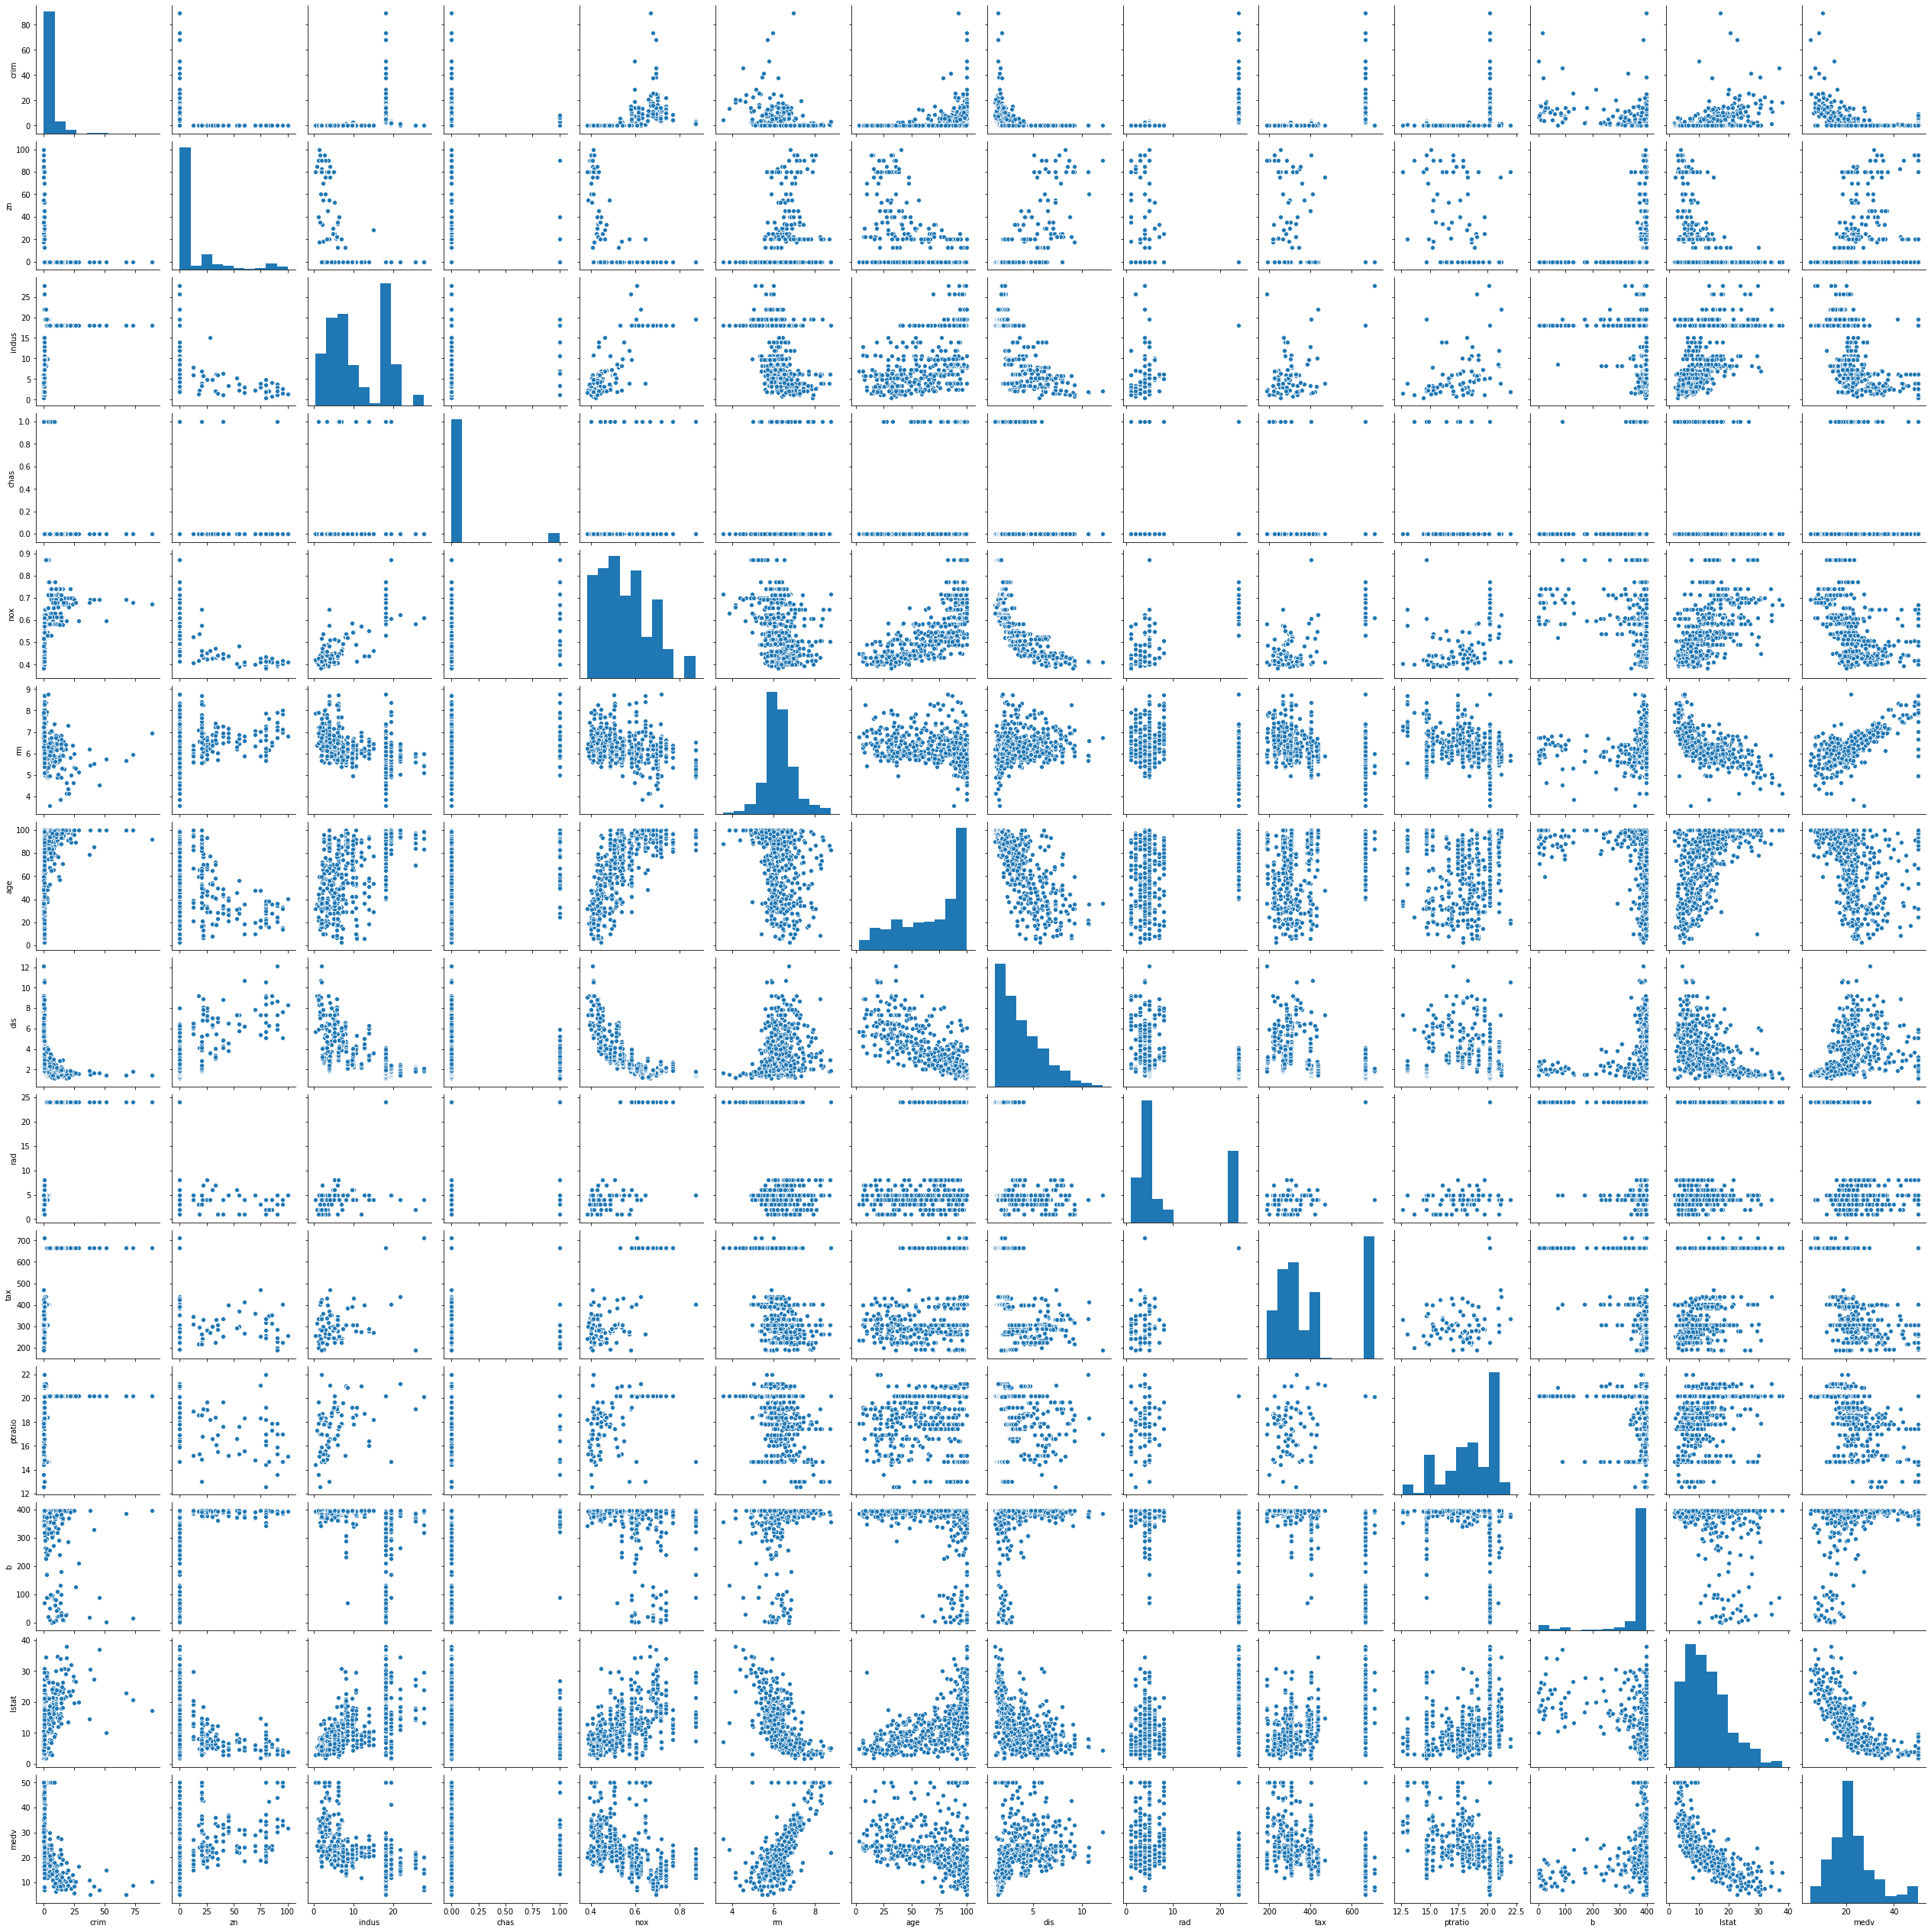

In [34]:
sns.pairplot(boston)

A heatmap is also presented:

[]

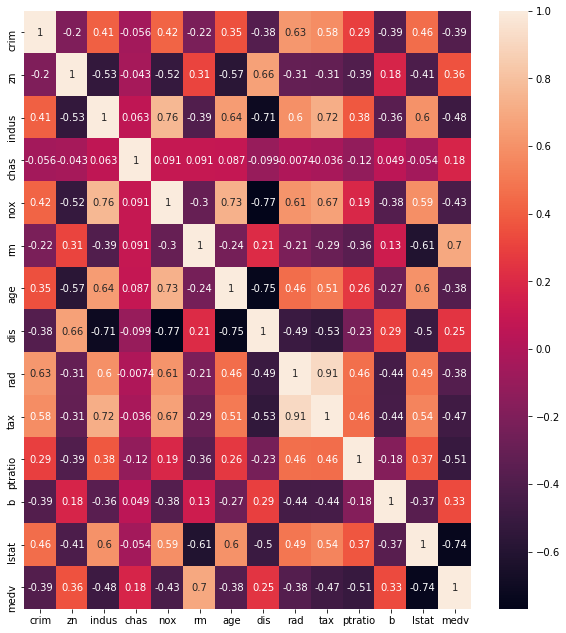

In [35]:
plt.figure(figsize=(10,11))
sns.heatmap(cc,annot=True)
plt.plot()

Finally, let's calculate the statisical significance for coefficients. The statistical significance is a kind of sensitivity analysis for the coefficients. It shows how sensitive the model is to coefficient changes. To calculate the statistical significance for each coefficient, we need to do a student's test (t test) and get the t values and p values. 

In [36]:
ttest =[]
pval = []
stat_sig = []

In [37]:
for column in X_train.T:
   temp1,temp2= ttest_ind(column,y_train)
   ttest.append(temp1)
   pval.append(temp2)

We've made a dataframe containing every feature variable, its corresponding coefficient, and the calculated t values and p values and printed them:

In [38]:
dep_variables = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax','ptratio', 'b', 'lstat']
coeff_evals = pd.DataFrame({'variables':dep_variables,'coefficients':coeffs[1:], 't-value':ttest, 'p-value':pval})
print(coeff_evals)

   variables  coefficients    t-value        p-value
0       crim     -0.113056 -29.946214  4.830126e-133
1         zn      0.030110  -9.040140   1.144011e-18
2      indus      0.040381 -20.461279   2.903241e-75
3       chas      2.784438 -48.926233  1.589608e-243
4        nox    -17.202633 -47.897223  5.494937e-238
5         rm      4.438835 -35.394184  2.673480e-166
6        age     -0.006296  31.168463  1.451363e-140
7        dis     -1.447865 -39.870918  7.584058e-193
8        rad      0.262430 -21.298673   3.342493e-80
9        tax     -0.010647  46.040586  7.563064e-228
10   ptratio     -0.915456  -9.381443   6.441747e-20
11         b      0.012351  72.825284   0.000000e+00
12     lstat     -0.508571 -17.713091   1.514279e-59


Let's see what the values mean. Take nox for example. The coefficient of -17.2 means that if we increase the value of nox by 1, the predicted value for medv will decrease by 17.2, as opposed to zn for instance, where an increase of zn by 1, will lead to an increase of the prediction by 0.03. This simply means that the model is very sensitive to changes in the nox coefficient, while it's not that sensitive to changes in zn. 

The p values obtained from the t values also show the statistical significance of the coefficients. The higher the values, the more significant they are to the response variable. 

<h2>Recourses</h2>

1. Eldén, L. (2019). Matrix methods in data mining and pattern recognition (Vol. 15). Siam.
2. https://www.quora.com/Why-use-a-tensor-decomposition-and-not-just-concatenate-my-matrices-and-use-matrix-decompositions
3. https://austingwalters.com/gauss-seidel-method/
4. https://stackoverflow.com/questions/53251299/successive-over-relaxation
5. https://en.wikipedia.org/wiki/Successive_over-relaxation#Formulation
6. https://math.stackexchange.com/questions/2462931/what-are-the-benefits-of-iterative-method-against-lu-decomposition
7. https://towardsdatascience.com/multiple-linear-regression-from-scratch-in-numpy-36a3e8ac8014
8. https://medium.com/analytics-vidhya/multiple-linear-regression-with-python-98f4a7f1c26c
9. https://towardsdatascience.com/hypothesis-testing-in-machine-learning-using-python-a0dc89e169ce